# 효율적 경계선 Part I

이번 시간에는 기대 수익률(**expected returns**)과 변동성(**volatility**)(또는 분산), 그리고 상관관계(**correlation**)(또는 공분산) 집합이 있을 때 효율적 경계선(**efficient frontier**)을 도출하는 방법에 대해 학습할 것입니다. 미래의 값들을 얻을 수 있는가는 당연히 합리적인 의문입니다. 하지만 일단 현재로서는 역사적 수익률이 합리적인 추정치라고 가정하겠습니다. (당연히 우리는 미래를 예측할 수 없습니다.) 추후 다른 세션에서는 이러한 추정치를 개선하는 방법에 대해 배울 예정입니다.

우선 새로운 데이터셋을 가져오는 것부터 시작하겠습니다. 이것은 30개의 서로 다른 섹터 포트폴리오의 수익률에 대한 [케네스 프렌치](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html)의 데이터 세트입니다.

이 데이터 파일에는 다음과 같은 몇 가지 사소한 문제가 있습니다.

In [1]:
import pandas as pd
ind = pd.read_csv("data/ind30_m_vw_rets.csv", header=0, index_col=0)/100
ind.index = pd.to_datetime(ind.index, format="%Y%m").to_period('M')

In [4]:
ind.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,0.0056,-0.0519,0.0129,0.0293,0.1097,-0.0048,0.0808,0.0177,0.0814,0.0039,...,0.0083,0.0922,0.0206,0.0770,0.0191,-0.2379,0.0007,0.0187,-0.0002,0.0520
1926-08,0.0259,0.2703,0.0650,0.0055,0.1001,-0.0358,-0.0251,0.0425,0.0550,0.0797,...,0.0217,0.0202,0.0439,-0.0238,0.0485,0.0539,-0.0075,-0.0013,0.0447,0.0676
1926-09,0.0116,0.0402,0.0126,0.0658,-0.0099,0.0073,-0.0051,0.0069,0.0533,0.0230,...,0.0241,0.0225,0.0019,-0.0554,0.0007,-0.0787,0.0025,-0.0056,-0.0161,-0.0386
1926-10,-0.0306,-0.0331,0.0106,-0.0476,0.0947,-0.0468,0.0012,-0.0057,-0.0476,0.0100,...,-0.0011,-0.0200,-0.0109,-0.0508,-0.0261,-0.1538,-0.0220,-0.0411,-0.0551,-0.0849
1926-11,0.0635,0.0729,0.0455,0.0166,-0.0580,-0.0054,0.0187,0.0542,0.0520,0.0310,...,0.0163,0.0377,0.0364,0.0384,0.0161,0.0467,0.0652,0.0433,0.0234,0.0400


In [5]:
ind.columns

Index(['Food ', 'Beer ', 'Smoke', 'Games', 'Books', 'Hshld', 'Clths', 'Hlth ',
       'Chems', 'Txtls', 'Cnstr', 'Steel', 'FabPr', 'ElcEq', 'Autos', 'Carry',
       'Mines', 'Coal ', 'Oil  ', 'Util ', 'Telcm', 'Servs', 'BusEq', 'Paper',
       'Trans', 'Whlsl', 'Rtail', 'Meals', 'Fin  ', 'Other'],
      dtype='object')

Note that the column names have embedded spaces. We can strip out the leading and trailing spaces in the Series by using the `.str.strip` method.

In [6]:
ind.columns = ind.columns.str.strip()

In [7]:
ind.shape

(1143, 30)

나중에 다시 사용할 수 있도록 다음 코드를 모듈에 추가하겠습니다.

```python
def get_ind_returns():
    """
    Load and format the Ken French 30 Industry Portfolios Value Weighted Monthly Returns
    """
    ind = pd.read_csv("data/ind30_m_vw_rets.csv", header=0, index_col=0)/100
    ind.index = pd.to_datetime(ind.index, format="%Y%m").to_period('M')
    ind.columns = ind.columns.str.strip()
    return ind
```

그런 다음 평소와 같이 모듈이 잘 로드되는지 테스트합니다.

In [11]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import port_opt_toolkit as potk
ind = potk.get_ind_returns()
ind.shape

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(1143, 30)

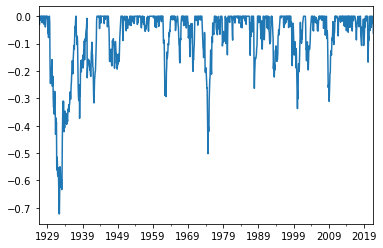

In [12]:
potk.drawdown(ind["Food"])["Drawdown"].plot.line()

In [13]:
potk.var_gaussian(ind[["Food", "Beer", "Smoke"]], modified=True)

Food     0.061233
Beer     0.033630
Smoke    0.080630
dtype: float64

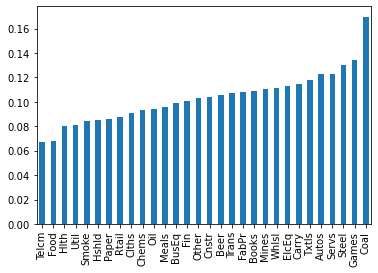

In [14]:
potk.var_gaussian(ind).sort_values().plot.bar()

이참에 연간 수익률, 변동성 및 샤프 비율에 대한 함수를 작성해 `port_opt_toolkit.py` 파일에 추가해놓겠습니다.

```python
def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1

def annualize_vol(r, periods_per_year):
    """
    Annualizes the vol of a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    return r.std()*(periods_per_year**0.5)

def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Computes the annualized sharpe ratio of a set of returns
    """
    # convert the annual riskfree rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol

```

In [15]:
potk.sharpe_ratio(ind, 0.03, 12).sort_values()

Coal     0.073927
Steel    0.138694
Whlsl    0.157768
Other    0.168620
Txtls    0.198249
Mines    0.198357
Books    0.208943
Games    0.210637
Trans    0.222533
Cnstr    0.250191
Autos    0.269612
Carry    0.275724
FabPr    0.288557
Fin      0.289608
Servs    0.293489
Clths    0.309272
ElcEq    0.310602
Util     0.311168
Oil      0.311710
Hshld    0.322848
Chems    0.344919
Meals    0.345154
Beer     0.356638
Paper    0.362358
BusEq    0.376049
Rtail    0.386585
Telcm    0.394737
Smoke    0.447904
Hlth     0.451175
Food     0.457837
dtype: float64

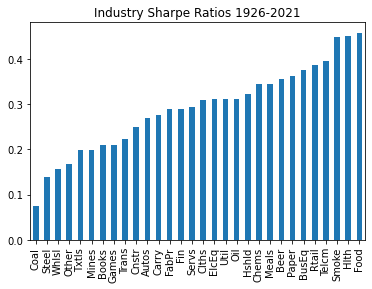

In [17]:
potk.sharpe_ratio(ind, 0.03, 12).sort_values().plot.bar(title="Industry Sharpe Ratios 1926-2021")

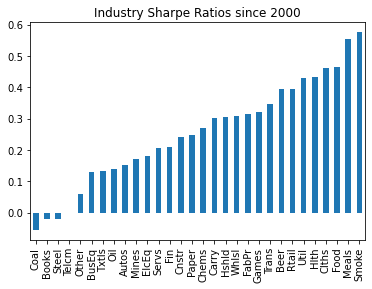

In [18]:
potk.sharpe_ratio(ind["2000":], 0.03, 12).sort_values().plot.bar(title='Industry Sharpe Ratios since 2000')

## 기대 수익률과 공분산 행렬

효율적 경계선을 생성하기 위해서는 기대 수익률(**expected returns**)과 공분산 행렬(**covariance matrix**)이 필요합니다. 지금은 단순히 역사적 추정치가 미래에도 유지될 것이라고 단순하게 가정해 보겠습니다.

기대 수익률의 벡터를 반환하는 `annualize_rets()` 함수를 사용하여 기대 수익률의 추정치를 생성할 수 있습니다. 예를 들어, 1996년부터 2000년까지 5년 동안의 역사적 수익률을 기반으로 기대 수익률 집합을 생성해 보겠습니다.

In [19]:
er = potk.annualize_rets(ind["1995":"2000"], 12)

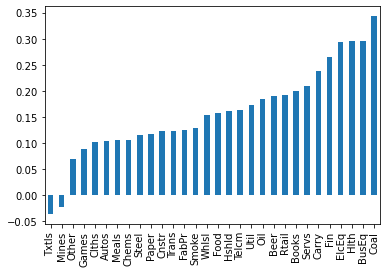

In [20]:
er.sort_values().plot.bar()

마지막으로 공분산 행렬을 생성해 보겠습니다. 판다스의 `.cov` 메서드를 사용하면 매우 쉽게 공분산 행렬을 구할 수 있습니다.

In [21]:
cov = ind["1995":"2000"].cov()
cov.shape

(30, 30)

다음 실습 세션에서는 기대 수익률 벡터와 공분산 행렬을 사용하여 효율적 경계선을 만들어보겠습니다.